# Adding dephasing

In this notebook we add pure dephasing to the transmon and fluxonium qubits. We will deal with the case of $1/f$ noise in the fluxonium away from the sweetspot separately.  

In [1]:
import numpy as np
import time
import qutip as qtp
import matplotlib.pyplot as plt
import pysqkit
import time
from pysqkit.util.phys import temperature_to_thermalenergy
import pysqkit.util.transformations as trf
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from IPython.display import display, Latex

The Hamiltonian of the transmon is approximated to be that of a Duffing oscillator
$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

while the Hamiltonian of the fluxonium is

$$H_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\phi}^2_F - E_{J,F}\cos\left(\hat{\phi}_F - \phi_{ext,F}\right),$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In what follows we want to study in particular a simplified model of Markovian dephasing. The Lindblad master equation associated with pure dephasing in the multi-level case can be found in Eq. 24 of PRX Quantum 2, 030306 (2021) and reads for both transmon and fluxonium (and any multi-level system)

$$
\frac{d \rho}{dt} = \frac{1}{i \hbar}\bigl[H_{S}, \rho \bigr] + \mathcal{D}[Z_{\mathrm{\phi}}](\rho),
$$

where $H_S$ is the Hamiltonian of the system, $\mathcal{D}[A](\rho) = A \rho A^{\dagger} - \frac{1}{2}\{A^{\dagger} A, \rho\}$ the Lindblad superoperator and we defined the multi-level dephasing operator

$$
Z_{\phi} = \sum_{i=0}^{+ \infty} \sqrt{2 \Gamma_{\phi, i}} |i \rangle \langle i |.
$$

with $|i \rangle$ eigenstates of $H_S$ and $\Gamma_{\phi, i}$ the dephasing rate associated with the state $i$. By using the resolution of the identity in the diagonal basis $\sum_{i=0}^{\infty} |i \rangle \langle i| $ one can see that we can set one of the $\Gamma_{\phi, i}$ to zero. In what follows we assume that we set the dephasing rate of the groundstate to zero, \i.e., $\Gamma_{\phi, 0}=0$. By doing so the coefficients $\Gamma_{\phi, i}$ have the interpretation of dephasing rates associated with the transition $|i \rangle-|0 \rangle$, as we will confirm numerically below.

For the numerical example we take exaggerately short dephasing times just for the purpose of keeping the simulation time short.

# 1) Fluxonium


In [2]:
#Fluxonium
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=8.0, 
    diel_loss_tan=1e-6*0.0, #setting it to zero to isolate effect of dephasing
    env_thermal_energy=0.0,
    dephasing_times = {'1': 2*np.pi*100, '3': 2*np.pi*10} #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

We now want to study numerically dephasing in this system under the previous Markovian dephasing model. To do so we initialize the states 

$$
|+_{01} \rangle = \frac{1}{\sqrt{2}} \bigl(|0 \rangle + |1 \rangle \bigr),
$$

$$
|+_{03} \rangle = \frac{1}{\sqrt{2}} \bigl(|0 \rangle + |3 \rangle \bigr)
$$

and look at the decay of the coherences, \i.e., the averages of $|0 \rangle \langle 1 |$ and $|0 \rangle \langle 3 |$ respectively. We will also show that instead by initializing 

$$
|+_{02} \rangle = \frac{1}{\sqrt{2}} \bigl(|0 \rangle + |2 \rangle \bigr),
$$

no decay of the corresponding coherenc is observed.

In [3]:
lev_a = '0'
lev_b = '3'
state_in = 1/np.sqrt(2)*(flx.state(lev_a, as_qobj=True)[1] + flx.state(lev_b, as_qobj=True)[1])
rho_in = state_in*state_in.dag()
time_tot = 100 #ns
time_points = 100000
times = np.linspace(0, 2*np.pi*time_tot, time_points)
hamil_f = flx.hamiltonian(as_qobj=True)
lindblad_op_f = [flx.dephasing_op(as_qobj=True)]
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12 #these need to be specified or qutip starts to make too many errors...
simu_opt.rtol = 1e-10

In [4]:
start = time.time()

result = solvkit.integrate(times, state_in, hamil_f, [], [], lindblad_op_f, "mesolve", options=simu_opt)

end = time.time()

print("Computation time = " + str(end - start) + ' s')

Computation time = 3.8978567123413086 s


In [5]:
coherence_op_f = flx.state(lev_a, as_qobj=True)[1]*flx.state(lev_b, as_qobj=True)[1].dag()
avg_coherence_f = [qtp.expect(coherence_op_f, state) for state in result.states]

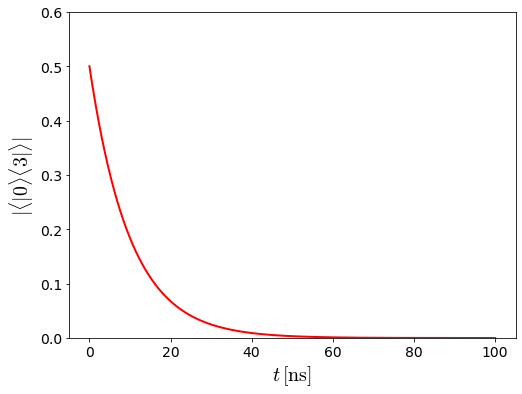

In [6]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
def plot_coherence(
    times: np.ndarray, 
    avg_coherence: List, 
    opt: dict,
    lev_a: str,
    lev_b: str
) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, np.abs(avg_coherence), linewidth=opt['lw'], color='red')
    ax.axes.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.axes.set_ylabel('$|\\langle |' + lev_a + '\\rangle \\langle ' + 
                       lev_b + '| \\rangle |$', fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.set_ylim(0, 0.6)
    plt.show()

plot_coherence(times/(2*np.pi), avg_coherence_f, plot_setup, lev_a, lev_b)

## 1.1) Comparison
We now compare the decays of the previous levels

In [7]:
state_01 = 1/np.sqrt(2)*(flx.state('0', as_qobj=True)[1] + flx.state('1', as_qobj=True)[1])
state_02 = 1/np.sqrt(2)*(flx.state('0', as_qobj=True)[1] + flx.state('2', as_qobj=True)[1])
state_03 = 1/np.sqrt(2)*(flx.state('0', as_qobj=True)[1] + flx.state('3', as_qobj=True)[1])
rho_01 = state_01*state_01.dag()
rho_02 = state_02*state_02.dag()
rho_03 = state_03*state_03.dag()

In [8]:
start = time.time()

result_01 = solvkit.integrate(times, state_01, hamil_f, [], [], lindblad_op_f, "mesolve", options=simu_opt)
result_02 = solvkit.integrate(times, state_02, hamil_f, [], [], lindblad_op_f, "mesolve", options=simu_opt)
result_03 = solvkit.integrate(times, state_03, hamil_f, [], [], lindblad_op_f, "mesolve", options=simu_opt)

end = time.time()

print("Computation time = " + str(end - start) + ' s')

Computation time = 11.180093050003052 s


In [9]:
coherence_op_01 = flx.state('0', as_qobj=True)[1]*flx.state('1', as_qobj=True)[1].dag()
coherence_op_02 = flx.state('0', as_qobj=True)[1]*flx.state('2', as_qobj=True)[1].dag()
coherence_op_03 = flx.state('0', as_qobj=True)[1]*flx.state('3', as_qobj=True)[1].dag()
avg_coherence_01 = [qtp.expect(coherence_op_01, state) for state in result_01.states]
avg_coherence_02 = [qtp.expect(coherence_op_02, state) for state in result_02.states]
avg_coherence_03 = [qtp.expect(coherence_op_03, state) for state in result_03.states]

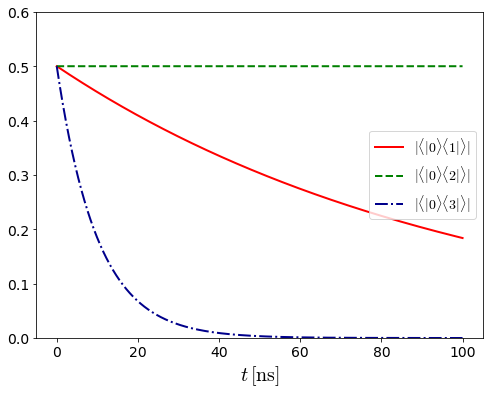

In [10]:
def plot_comparison_coherence(
    times: np.ndarray, 
    avg_coherence_01: List,
    avg_coherence_02: List,
    avg_coherence_03: List, 
    opt: dict,
) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, np.abs(avg_coherence_01), linestyle='-', linewidth=opt['lw'], color='red', 
           label='$|\\langle |0 \\rangle \\langle 1 | \\rangle |$')
    ax.plot(times, np.abs(avg_coherence_02), linestyle='--', linewidth=opt['lw'], color='green', 
           label='$|\\langle |0 \\rangle \\langle 2 | \\rangle |$')
    ax.plot(times, np.abs(avg_coherence_03), linestyle='-.', linewidth=opt['lw'], color='darkblue', 
           label='$|\\langle |0 \\rangle \\langle 3 | \\rangle |$')
    ax.axes.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs_text'], loc='center right')
    ax.set_ylim(0, 0.6)
    plt.show()

plot_comparison_coherence(times/(2*np.pi), avg_coherence_01, avg_coherence_02,
                          avg_coherence_03, plot_setup)

# 2) Transmon
We now do the same for a Transmon qubit.

In [11]:
#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=4.5, 
    anharm=-0.3,
    diel_loss_tan=0.75*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=0.0, 
    dephasing_times = {'1': 2*np.pi*100, '2': 2*np.pi*50},
    dim_hilbert=levels_t
)

In [12]:
lev_a = '0'
lev_b = '1'
state_in = 1/np.sqrt(2)*(transm.state(lev_a, as_qobj=True)[1] + transm.state(lev_b, as_qobj=True)[1])
rho_in = state_in*state_in.dag()
time_tot = 100 #ns
time_points = 100000
times = np.linspace(0, 2*np.pi*time_tot, time_points)
hamil_t = transm.hamiltonian(as_qobj=True)
lindblad_op_t = [transm.dephasing_op(as_qobj=True)]

In [13]:
start = time.time()

result = solvkit.integrate(times, state_in, hamil_t, [], [], lindblad_op_t, "mesolve", options=simu_opt)

end = time.time()

print("Computation time = " + str(end - start) + ' s')

Computation time = 3.5089893341064453 s


In [14]:
coherence_op_t = transm.state(lev_a, as_qobj=True)[1]*transm.state(lev_b, as_qobj=True)[1].dag()
avg_coherence_t = [qtp.expect(coherence_op_t, state) for state in result.states]

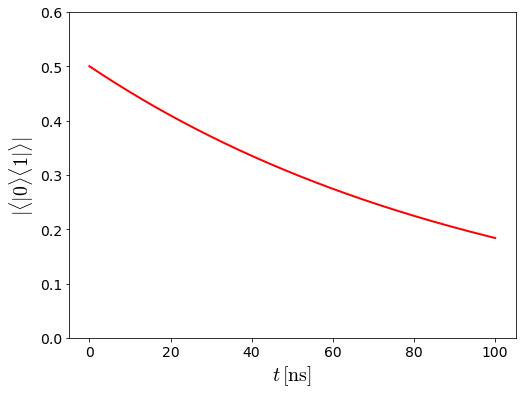

In [15]:
plot_coherence(times/(2*np.pi), avg_coherence_t, plot_setup, lev_a, lev_b)